#### Name: Sagar Nandeshwar
#### Student ID: 260920948

#### Please Note:
* Report is written at the end if the notebook 
* Describtion of methods, algorithm and choice of hyper-parameters are written in the codes

## Import Statements

In [1]:
import gymnasium as gym
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import copy
from sklearn.linear_model import LogisticRegression
env = gym.make('CartPole-v1')

## Hyper-parameters

In [2]:
gamma1 = 0.99 # discounting factor policy based algorithm
gamma2 = 0.95 # discounting factor off-policy algorithm
alpha = 1/16 # learning rate for the Expert and the Random agent
K = 5 # number of Fitted Q-learning iterations
alpha1 = 0.01 # learning rate 1 for off-policy algorithms
alpha2 = 0.001 # learning rate 2 for off-policy algorithms
epsilon1 = 0.10 # epsilon value for Greedy Algorithm in Q-learning
epsilon2 = 0.10 # epsilon value for Greedy Algorithm

## Discrete State Defination
<br>For each observation element (Posiiton, Velocity, Angle and Angular-Velcity) we difine 10 equal range/size bins (from 0 to 9). 
<br>This is done by dividing the whole range (max value - min value) of each elements by 10. (I got these max and min value from the environment, for varification I have ran the experiment 10^6 time with random action).
<br>We then define state in a form of tuple of length = 4, where index
<br>0 -> Posiiton
<br>1 -> Velocity
<br>2 -> Angle
<br>3 -> Angular-velcity
<br>So, each state could take two actions (i.e. 0 or 1)

In [3]:
POSITION_HIGH = 4.800
POSITION_LOW = -4.800
VELOCITY_HIGH = 3.402
VELOCITY_LOW = -3.402
ANGLE_HIGH = 4.188
ANGLE_LOW = -4.188
ANGLE_VELOCITY_HIGH = 3.402
ANGLE_VELOCITY_LOW = -3.402

"""
Method create bin information dictionay that defines the descrete bins,
which is used to define state
"""
def get_bins_def():
    bins_dict = {}
    start_pos = POSITION_LOW
    start_vel = VELOCITY_LOW
    start_ang = ANGLE_LOW
    start_ang_vel = ANGLE_VELOCITY_LOW
    range_pos = (POSITION_HIGH - POSITION_LOW) / 10
    range_vel = (VELOCITY_HIGH - VELOCITY_LOW) / 10
    range_ang = (ANGLE_HIGH - ANGLE_LOW) / 10
    range_ang_vel = (ANGLE_VELOCITY_HIGH - ANGLE_VELOCITY_LOW) / 10
    for bin in range(10):
        end_pos = start_pos + range_pos
        end_vel = start_vel + range_vel
        end_ang = start_ang + range_ang
        end_ang_vel = start_ang_vel + range_ang_vel
        bins_dict[bin] = {"pos_low": start_pos, 
                          "pos_high": end_pos, 
                          "vel_low": start_vel,
                          "vel_high": end_vel,
                          "ang_low": start_ang,
                          "ang_high": end_ang,
                          "ang_vel_low": start_ang_vel, 
                          "ang_vel_high": end_ang_vel}
        start_pos = start_pos + range_pos #+ 0.0001
        start_vel = start_vel + range_vel #+ 0.0001
        start_ang = start_ang + range_ang #+ 0.0001
        start_ang_vel = start_ang_vel + range_ang_vel #+ 0.0001
    return bins_dict

"""
The method returns the state (tuple) based on bin information, for given state,
"""
def get_bin_ind(array, bin_def):
    pos_bin = -1
    pos = round(array[0],2)
    for bins in bin_def:
        if pos <= bin_def[bins]["pos_high"]:# and pos >= bin_def[bins]["pos_low"]:
            pos_bin = bins
            break
    if pos_bin == -1:
        pos_bin = 9
    
    vel_bin = -1
    vel = round(array[1],2)
    for bins in bin_def:
        if vel <= bin_def[bins]["vel_high"]:# and vel >= bin_def[bins]["vel_low"]:
            vel_bin = bins
            break
    if vel_bin == -1:
        vel_bin = 9
    
    ang_bin = -1
    ang = round(array[2],2)
    for bins in bin_def:
        if ang <= bin_def[bins]["ang_high"]:# and ang >= bin_def[bins]["ang_low"]:
            ang_bin = bins
            break
    if ang_bin == -1:
        ang_bin = 9
    
    ang_vel_bin = -1
    ang_vel = round(array[3],2)
    for bins in bin_def:
        if ang_vel <= bin_def[bins]["ang_vel_high"]:# and ang_vel >= bin_def[bins]["ang_vel_low"]:
            ang_vel_bin = bins
            break
    if ang_vel_bin == -1:
        ang_vel_bin = 9
        
    return (pos_bin, vel_bin, ang_bin, ang_vel_bin)
    
bin_def = get_bins_def()

## Q table Initialization
The weights for the Q-function is initialized random between -0.001 and 0.001

In [4]:
def get_Q():
    Q = {}
    for a in range(10):
        for b in range(10):
            for c in range(10):
                for d in range(10):
                    Q[(a,b,c,d)] = [random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)]
    return Q

#Q_table = get_Q()

## Action Selection Methods

In [5]:
"""
Method to choose Q-Learning action
"""
def choose_action_Q_learning(Q, state):
    max_action = -1
    if Q[state][0] > Q[state][1]:
        max_action = 0
    elif Q[state][0] < Q[state][1]:
        max_action = 1
    else:
        max_action = random.randint(0, 1)
    exploit = np.random.binomial(1, 1-epsilon1)
    if exploit:
        return max_action
    else:
        return random.randint(0, 1)


"""
Method to get max state value of next_state
"""
def get_max_state_action_value(Q, state):
    if Q[state][0] > Q[state][1]:
        return Q[state][0]
    elif Q[state][0] < Q[state][1]:
        return Q[state][1]
    else:
        return Q[state][0]

"""
Method to choose Random action
"""
def choose_action_random(Q, state):
    return np.random.binomial(1, 0.5)

"""
Method to choose Greedy action
"""
def choose_action_greedy(Q, state):
    max_action = -1
    if Q[state][0] > Q[state][1]:
        max_action = 0
    elif Q[state][0] < Q[state][1]:
        max_action = 1
    else:
        max_action = random.randint(0, 1)
    exploit = np.random.binomial(1, 1-epsilon2)
    if exploit:
        return max_action
    else:
        return random.randint(0, 1)

## Pre-training Agents
I pre-trained the Q value function for each agents (Expert and Random), by sampling 10,000 episodes. 

In [6]:
def get_trained_q_qlearn(episodes, Q):
    for t in range(episodes):
        iter_n = 0
        
        start = env.reset()
        state = get_bin_ind(start[0], bin_def)
        
        terminated = False
        truncated = False
        
        while(True):
            action = choose_action_Q_learning(Q, state)
            observation, reward, terminated, truncated, info = env.step(action)
            
            next_state = get_bin_ind(observation, bin_def)
            
            cur_state_value = Q[state][action]
            next_state_value = get_max_state_action_value(Q, next_state)
            target = reward + (gamma1 * (1 - terminated) * next_state_value)
            Q[state][action] = Q[state][action] + alpha * (target - cur_state_value)
            
            state = next_state
            iter_n = iter_n + 1
            
            if terminated or truncated:
                break
    return Q
    
def get_trained_q_random(episodes, Q):
    for t in range(episodes):
        iter_n = 0
        
        start = env.reset()
        state = get_bin_ind(start[0], bin_def)
        action = choose_action_random(Q, state)
        
        terminated = False
        truncated = False
        
        while(True):
            action = choose_action_random(Q, state)
            observation, reward, terminated, truncated, info = env.step(action)
            
            next_state = get_bin_ind(observation, bin_def)
            next_action = choose_action_random(Q, next_state)
            
            cur_state_value = Q[state][action]
            next_state_value = Q[next_state][next_action]
            target = reward + (gamma1 * next_state_value)
            Q[state][action] = Q[state][action] + alpha * (target - cur_state_value)
            
            state = next_state
            action = next_action
            iter_n = iter_n + 1
            
            if terminated or truncated:
                break
    return Q


Q_qlearn = get_trained_q_qlearn(10000, get_Q())
#Q_random = get_trained_q_random(80000, get_Q())
Q_random = get_Q()

## Observations With Expert Policy
**Expert Policy:** For Expert Policy, I have decided to use Q-Learning with alpha = 1/8

In [7]:
def get_observation_expert(Qqlearn, episode):
    observation_dataset = []
    Q = copy.deepcopy(Qqlearn)
    for episode_n in range(episode):
        iter_n = 0
        
        epsiode_array = []
        
        start = env.reset()
        state = get_bin_ind(start[0], bin_def)
        
        terminated = False
        truncated = False
        
        while(True):
            action = choose_action_Q_learning(Q, state)
            observation, reward, terminated, truncated, info = env.step(action)
            
            next_state = get_bin_ind(observation, bin_def)
            
            cur_state_value = Q[state][action]
            next_state_value = get_max_state_action_value(Q, next_state)
            target = reward + (gamma1 * (1 - terminated) * next_state_value)
            Q[state][action] = Q[state][action] + alpha * (target - cur_state_value)
            
            a_data = (state, action, reward, next_state)
            epsiode_array.append(a_data)
            
            state = next_state
            iter_n = iter_n + 1
            
            if terminated or truncated:
                break
                                 
        observation_dataset.append(epsiode_array)
    return observation_dataset

observation_expert = get_observation_expert(Q_qlearn, 500)

## Observations With Random Policy

In [8]:
def get_observation_random(Qrandom, episode):
    observation_dataset = []
    Q = copy.deepcopy(Qrandom)
    for episode_n in range(episode):
        iter_n = 0
        
        epsiode_array = []
        
        start = env.reset()
        state = get_bin_ind(start[0], bin_def)
        action = choose_action_random(Q, state)
        
        terminated = False
        truncated = False
        
        while(True):
            observation, reward, terminated, truncated, info = env.step(action)
            
            next_state = get_bin_ind(observation, bin_def)
            next_action = choose_action_random(Q, next_state)
            
            cur_state_value = Q[state][action]
            next_state_value = Q[next_state][next_action]
            target = reward + (gamma1 * next_state_value)
            Q[state][action] = Q[state][action] + alpha * (target - cur_state_value)
            
            a_data = (state, action, reward, next_state)
            epsiode_array.append(a_data)
            
            state = next_state
            action = next_action
            iter_n = iter_n + 1
            
            if terminated or truncated:
                break
                                 
        observation_dataset.append(epsiode_array)   
    return observation_dataset

observation_random = get_observation_random(Q_random, 500)

## Observation With Half Policy (Half Expert and Half Random Policy)
**Half Policy:** For even number episode we apply Random policy and for odd number episode we apply Expert Policy

In [9]:
def get_observation_half(Q_qlearn_table, Q_random_table, episode):
    observation_dataset = []
    Qqlearn = copy.deepcopy(Q_qlearn_table)
    Qrandom = copy.deepcopy(Q_random_table)
    for episode_n in range(episode):
        epsiode_array = []
        if (episode_n%2 == 0):
            iter_n = 0
            
            start = env.reset()
            state = get_bin_ind(start[0], bin_def)
            action = choose_action_random(Qrandom, state)
        
            terminated = False
            truncated = False
        
            while(True):
                observation, reward, terminated, truncated, info = env.step(action)
            
                next_state = get_bin_ind(observation, bin_def)
                next_action = choose_action_random(Qrandom, next_state)
            
                cur_state_value = Qrandom[state][action]
                next_state_value = Qrandom[next_state][next_action]
                target = reward + (gamma1 * next_state_value)
                Qrandom[state][action] = Qrandom[state][action] + alpha * (target - cur_state_value)
            
                a_data = (state, action, reward, next_state)
                epsiode_array.append(a_data)
            
                state = next_state
                action = next_action
                iter_n = iter_n + 1
            
                if terminated or truncated:
                    break
                                 
            observation_dataset.append(epsiode_array)
        
        else:
            iter_n = 0
            
            start = env.reset()
            state = get_bin_ind(start[0], bin_def)
        
            terminated = False
            truncated = False
        
            while(True):
                action = choose_action_Q_learning(Qqlearn, state)
                observation, reward, terminated, truncated, info = env.step(action)
            
                next_state = get_bin_ind(observation, bin_def)
            
                cur_state_value = Qqlearn[state][action]
                next_state_value = get_max_state_action_value(Qqlearn, next_state)
                target = reward + (gamma1 * (1 - terminated) * next_state_value)
                Qqlearn[state][action] = Qqlearn[state][action] + alpha * (target - cur_state_value)
            
                a_data = (state, action, reward, next_state)
                epsiode_array.append(a_data)
            
                state = next_state
                iter_n = iter_n + 1
            
                if terminated or truncated:
                    break
                                 
            observation_dataset.append(epsiode_array) 
    return observation_dataset

observation_half = get_observation_half(Q_qlearn, Q_random, 500)

## Creating dataset of 100, 250 and 500 episodes
From the 500 oberservation we collected in the previous section, we create datasets of size 100, 250 and 500 for each three policy.

In [10]:
def create_datesets(obs):
    array_100 = []
    array_250 = []
    array_500 = []
    iter_n = 0
    for element in obs:
        if iter_n < 100:
            array_100.append(element)
            array_250.append(element)
            array_500.append(element)
        elif iter_n < 250:
            array_250.append(element)
            array_500.append(element)
        else:
            array_500.append(element)
        iter_n = iter_n + 1 
    return array_100, array_250, array_500

observation_expert_100, observation_expert_250, observation_expert_500 = create_datesets(observation_expert)
observation_random_100, observation_random_250, observation_random_500 = create_datesets(observation_random)
observation_half_100, observation_half_250, observation_half_500 = create_datesets(observation_half)

## Fitted Q-learning
I have set hyperparameter K to 5. I observed that the Q-function values drift very quickly when k is more than 5

In [11]:
def fitted_qlearn(dataset, Q, alpha):
    for k in range(K):
        for epidoes in dataset:
            for element in epidoes:
                y = element[2] + (gamma2 * get_max_state_action_value(Q, element[3]))
                difference = y - Q[element[0]][element[1]]
                Q[element[0]][element[1]] += (alpha * difference)
  
    greedy_return = []  
    for episode_n in range(100): 
        iter_n = 0
        
        epsiode_array = []
        
        start = env.reset()
        state = get_bin_ind(start[0], bin_def)
        action = choose_action_greedy(Q, state)
        
        terminated = False
        truncated = False
        
        while(True):
            observation, reward, terminated, truncated, info = env.step(action)
            
            next_state = get_bin_ind(observation, bin_def)
            next_action = choose_action_greedy(Q, next_state)
            
            epsiode_array.append((state, action, reward, next_state))
            
            state = next_state
            action = next_action
            iter_n = iter_n + 1
            
            if terminated or truncated:
                break
        greedy_return.append(epsiode_array)
    return greedy_return
  

return_expert_fqn_500_alpha1 = fitted_qlearn(observation_expert_500, get_Q(), alpha1)
return_random_fqn_500_alpha1 = fitted_qlearn(observation_random_500, get_Q(), alpha1)
return_half_fqn_500_alpha1 = fitted_qlearn(observation_half_500, get_Q(), alpha1)

return_expert_fqn_250_alpha1 = fitted_qlearn(observation_expert_250, get_Q(), alpha1)
return_random_fqn_250_alpha1 = fitted_qlearn(observation_random_250, get_Q(), alpha1)
return_half_fqn_250_alpha1 = fitted_qlearn(observation_half_250, get_Q(), alpha1)

return_expert_fqn_100_alpha1 = fitted_qlearn(observation_expert_100, get_Q(), alpha1)
return_random_fqn_100_alpha1 = fitted_qlearn(observation_random_100, get_Q(), alpha1)
return_half_fqn_100_alpha1 = fitted_qlearn(observation_half_100, get_Q(), alpha1)




return_expert_fqn_500_alpha2 = fitted_qlearn(observation_expert_500, get_Q(), alpha2)
return_random_fqn_500_alpha2 = fitted_qlearn(observation_random_500, get_Q(), alpha2)
return_half_fqn_500_alpha2 = fitted_qlearn(observation_half_500, get_Q(), alpha2)

return_expert_fqn_250_alpha2 = fitted_qlearn(observation_expert_250, get_Q(), alpha2)
return_random_fqn_250_alpha2 = fitted_qlearn(observation_random_250, get_Q(), alpha2)
return_half_fqn_250_alpha2 = fitted_qlearn(observation_half_250, get_Q(), alpha2)

return_expert_fqn_100_alpha2 = fitted_qlearn(observation_expert_100, get_Q(), alpha2)
return_random_fqn_100_alpha2 = fitted_qlearn(observation_random_100, get_Q(), alpha2)
return_half_fqn_100_alpha2 = fitted_qlearn(observation_half_100, get_Q(), alpha2)

## Imitation learning with Logistic regression
For Imitation learning with Logistic regression, I, essentially, try to predict action with the highest probability for a state. 

I have derived the following equation: 
<br> pi(a|s(t+1)) = a(t) + alpha * pi(a|s(t)) 

This is done to give preference to the episode observed during later section of datasets; it is helpful for the Expert agent, as they try to learn and improve their Q- function value table gradually. For random agent it may not matter.

Algorithm: 
- I first initialize the pi-table (action table) for each state with 0.5 
- As I update pi with the observation's dataset the value of pi(a|s) converges to 0 or 1.  
- I round off the values to create label (0 or 1) for y  
- I create X of dimension 10000 x 4, where row represent state and column correspond the observation space. 
- I use these X and y to build Logistic Regression Model. 
- I use the model to predict the action of each state during Greedy Exploration. 

In [12]:
def imitation_learning(dataset, Qt, alpha):
    # Initialization with 0.5
    X_table = {}
    for states in Qt:
        X_table[states] = 0.5
    
    # Update Q table
    for episode in dataset:
        for element in episode:
            X_table[element[0]] = element[1] + alpha * X_table[element[0]]
            
    # Remove all the values with 0.5
    X_table_new = {}
    for states in X_table:
        if X_table[states] == 0.5:
            continue
        X_table_new[states] = X_table[states]
        
    # Initializing X and Y for logistic regression
    X = np.empty([len(X_table_new), 4])
    y = []
    iter_n = 0
    for x_state in X_table_new:
        X[iter_n] = [x_state[0], x_state[1], x_state[2], x_state[3]]
        y.append(round(X_table_new[x_state]))
        iter_n = iter_n + 1
    
    clf = LogisticRegression().fit(X, y)
    greedy_return = []     
    for episode_n in range(100): 
        iter_n = 0
        
        epsiode_array = []
        
        start = env.reset()
        state = get_bin_ind(start[0], bin_def)
        
        action_lr = clf.predict([[state[0], state[1], state[2], state[3]]])
        action = int(action_lr[0])
        
        terminated = False
        truncated = False
        
        while(True):
            observation, reward, terminated, truncated, info = env.step(action)
            
            next_state = get_bin_ind(observation, bin_def)
            
            next_action_lr = clf.predict([[next_state[0], next_state[1], next_state[2], next_state[3]]])
            next_action = int(next_action_lr[0])
            
            a_data = (state, action, reward, next_state)
            epsiode_array.append(a_data)
            
            state = next_state
            action = next_action
            iter_n = iter_n + 1
            
            if terminated or truncated:
                break
        greedy_return.append(epsiode_array)

    return greedy_return


    
return_expert_lr_500_alpha1 = imitation_learning(observation_expert_500, get_Q(), alpha1)
return_random_lr_500_alpha1 = imitation_learning(observation_random_500, get_Q(), alpha1)
return_half_lr_500_alpha1 = imitation_learning(observation_half_500, get_Q(), alpha1)

return_expert_lr_250_alpha1 = imitation_learning(observation_expert_250, get_Q(), alpha1)
return_random_lr_250_alpha1 = imitation_learning(observation_random_250, get_Q(), alpha1)
return_half_lr_250_alpha1 = imitation_learning(observation_half_250, get_Q(), alpha1)

return_expert_lr_100_alpha1 = imitation_learning(observation_expert_100, get_Q(), alpha1)
return_random_lr_100_alpha1 = imitation_learning(observation_random_100, get_Q(), alpha1)
return_half_lr_100_alpha1 = imitation_learning(observation_half_100, get_Q(), alpha1)


return_expert_lr_500_alpha2 = imitation_learning(observation_expert_500, get_Q(), alpha2)
return_random_lr_500_alpha2 = imitation_learning(observation_random_500, get_Q(), alpha2)
return_half_lr_500_alpha2 = imitation_learning(observation_half_500, get_Q(), alpha2)

return_expert_lr_250_alpha2 = imitation_learning(observation_expert_250, get_Q(), alpha2)
return_random_lr_250_alpha2 = imitation_learning(observation_random_250, get_Q(), alpha2)
return_half_lr_250_alpha2 = imitation_learning(observation_half_250, get_Q(), alpha2)

return_expert_lr_100_alpha2 = imitation_learning(observation_expert_100, get_Q(), alpha2)
return_random_lr_100_alpha2 = imitation_learning(observation_random_100, get_Q(), alpha2)
return_half_lr_100_alpha2 = imitation_learning(observation_half_100, get_Q(), alpha2)

## Agent Average Returns 

In [13]:
expert_mean_arr_100 = []
random_mean_arr_100 = []
expert_mean_arr_250 = []
random_mean_arr_250 = []
expert_mean_arr_500 = []
random_mean_arr_500 = []


for epidoes in observation_expert_100:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    expert_mean_arr_100.append(sum_e) 
    
for epidoes in observation_random_100:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    random_mean_arr_100.append(sum_e) 
    
for epidoes in observation_expert_250:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    expert_mean_arr_250.append(sum_e) 
    
for epidoes in observation_random_250:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    random_mean_arr_250.append(sum_e) 
    
for epidoes in observation_expert_500:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    expert_mean_arr_500.append(sum_e) 
    
for epidoes in observation_random_500:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    random_mean_arr_500.append(sum_e) 
    
    
expert_mean_100 = np.mean(expert_mean_arr_100)
random_mean_100 = np.mean(random_mean_arr_100)
expert_mean_250 = np.mean(expert_mean_arr_250)
random_mean_250 = np.mean(random_mean_arr_250)
expert_mean_500 = np.mean(expert_mean_arr_500)
random_mean_500 = np.mean(random_mean_arr_500)

## Bar Chart for Observation = 100, learning rate = 1/8 

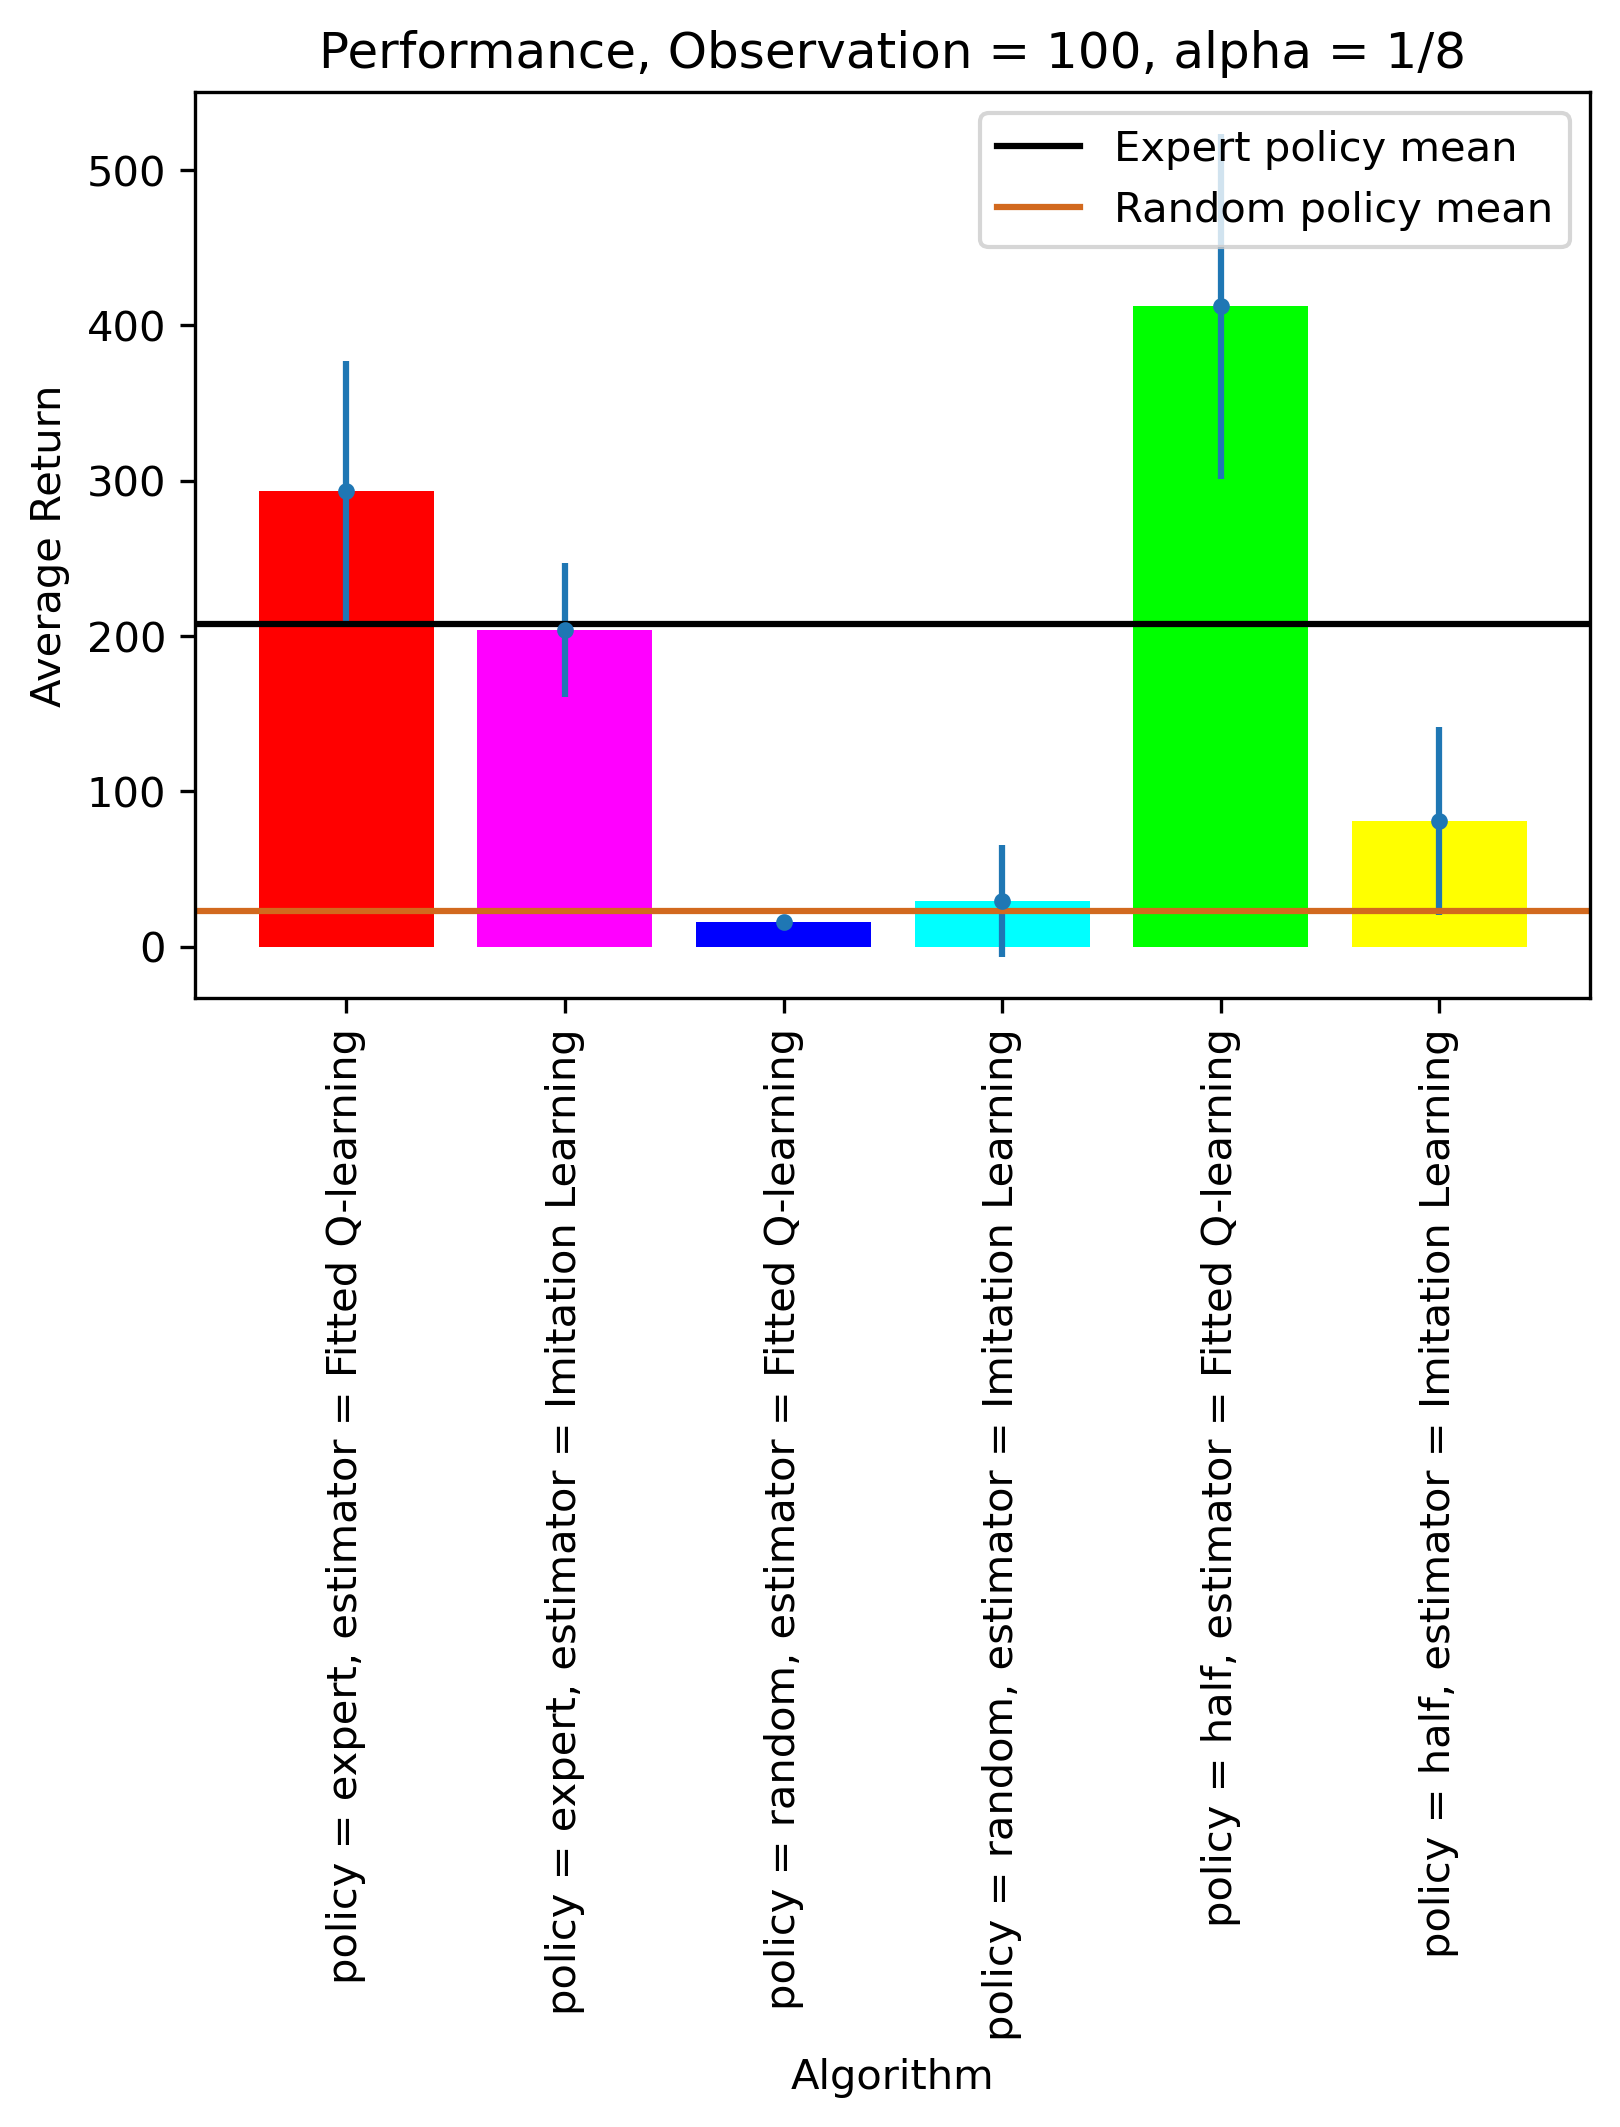

In [20]:
y_axis_1 = []
y_axis_2 = []
y_axis_3 = []
y_axis_4 = []
y_axis_5 = []
y_axis_6 = []


for epidoes in return_expert_fqn_100_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_1.append(sum_e)
    
for epidoes in return_expert_lr_100_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_2.append(sum_e)
    
for epidoes in return_random_fqn_100_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_3.append(sum_e)
    
for epidoes in return_random_lr_100_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_4.append(sum_e)
    
for epidoes in return_half_fqn_100_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_5.append(sum_e)
    
for epidoes in return_half_lr_100_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_6.append(sum_e)
    

y_axis_1_mean = np.mean(y_axis_1)
y_axis_2_mean = np.mean(y_axis_2)      
y_axis_3_mean = np.mean(y_axis_3)
y_axis_4_mean = np.mean(y_axis_4)      
y_axis_5_mean = np.mean(y_axis_5)      
y_axis_6_mean = np.mean(y_axis_6)   

y_axis_1_sd = np.std(y_axis_1)
y_axis_2_sd = np.std(y_axis_2)      
y_axis_3_sd = np.std(y_axis_3)
y_axis_4_sd = np.std(y_axis_4)      
y_axis_5_sd = np.std(y_axis_5)      
y_axis_6_sd = np.std(y_axis_6)

y = []
y.append(y_axis_1_mean)
y.append(y_axis_2_mean)
y.append(y_axis_3_mean)
y.append(y_axis_4_mean)
y.append(y_axis_5_mean)
y.append(y_axis_6_mean)

y_err = []
y_err.append(y_axis_1_sd)
y_err.append(y_axis_2_sd)
y_err.append(y_axis_3_sd)
y_err.append(y_axis_4_sd)
y_err.append(y_axis_5_sd)
y_err.append(y_axis_6_sd)

x = ['policy = expert, estimator = Fitted Q-learning', 
            'policy = expert, estimator = Imitation Learning',
            'policy = random, estimator = Fitted Q-learning',
            'policy = random, estimator = Imitation Learning',
            'policy = half, estimator = Fitted Q-learning',
            'policy = half, estimator = Imitation Learning',
           ]


plt.figure(dpi=300)
plt.bar(x, y, color=['#FF0000','#FF00FF','#0000FF','#00FFFF','#00FF00','#FFFF00'])
plt.errorbar(x, y, y_err, fmt='.')
plt.axhline(expert_mean_100, color='#000000')
plt.axhline(random_mean_100, color='#D2691E')
plt.legend(['Expert policy mean', 'Random policy mean'])
plt.xlabel("Algorithm",)
plt.ylabel("Average Return")
plt.title("Performance, Observation = 100, alpha = 1/8")
plt.xticks(rotation=90)
plt.show()


## Bar Chart for Observation = 100, learning rate = 1/16

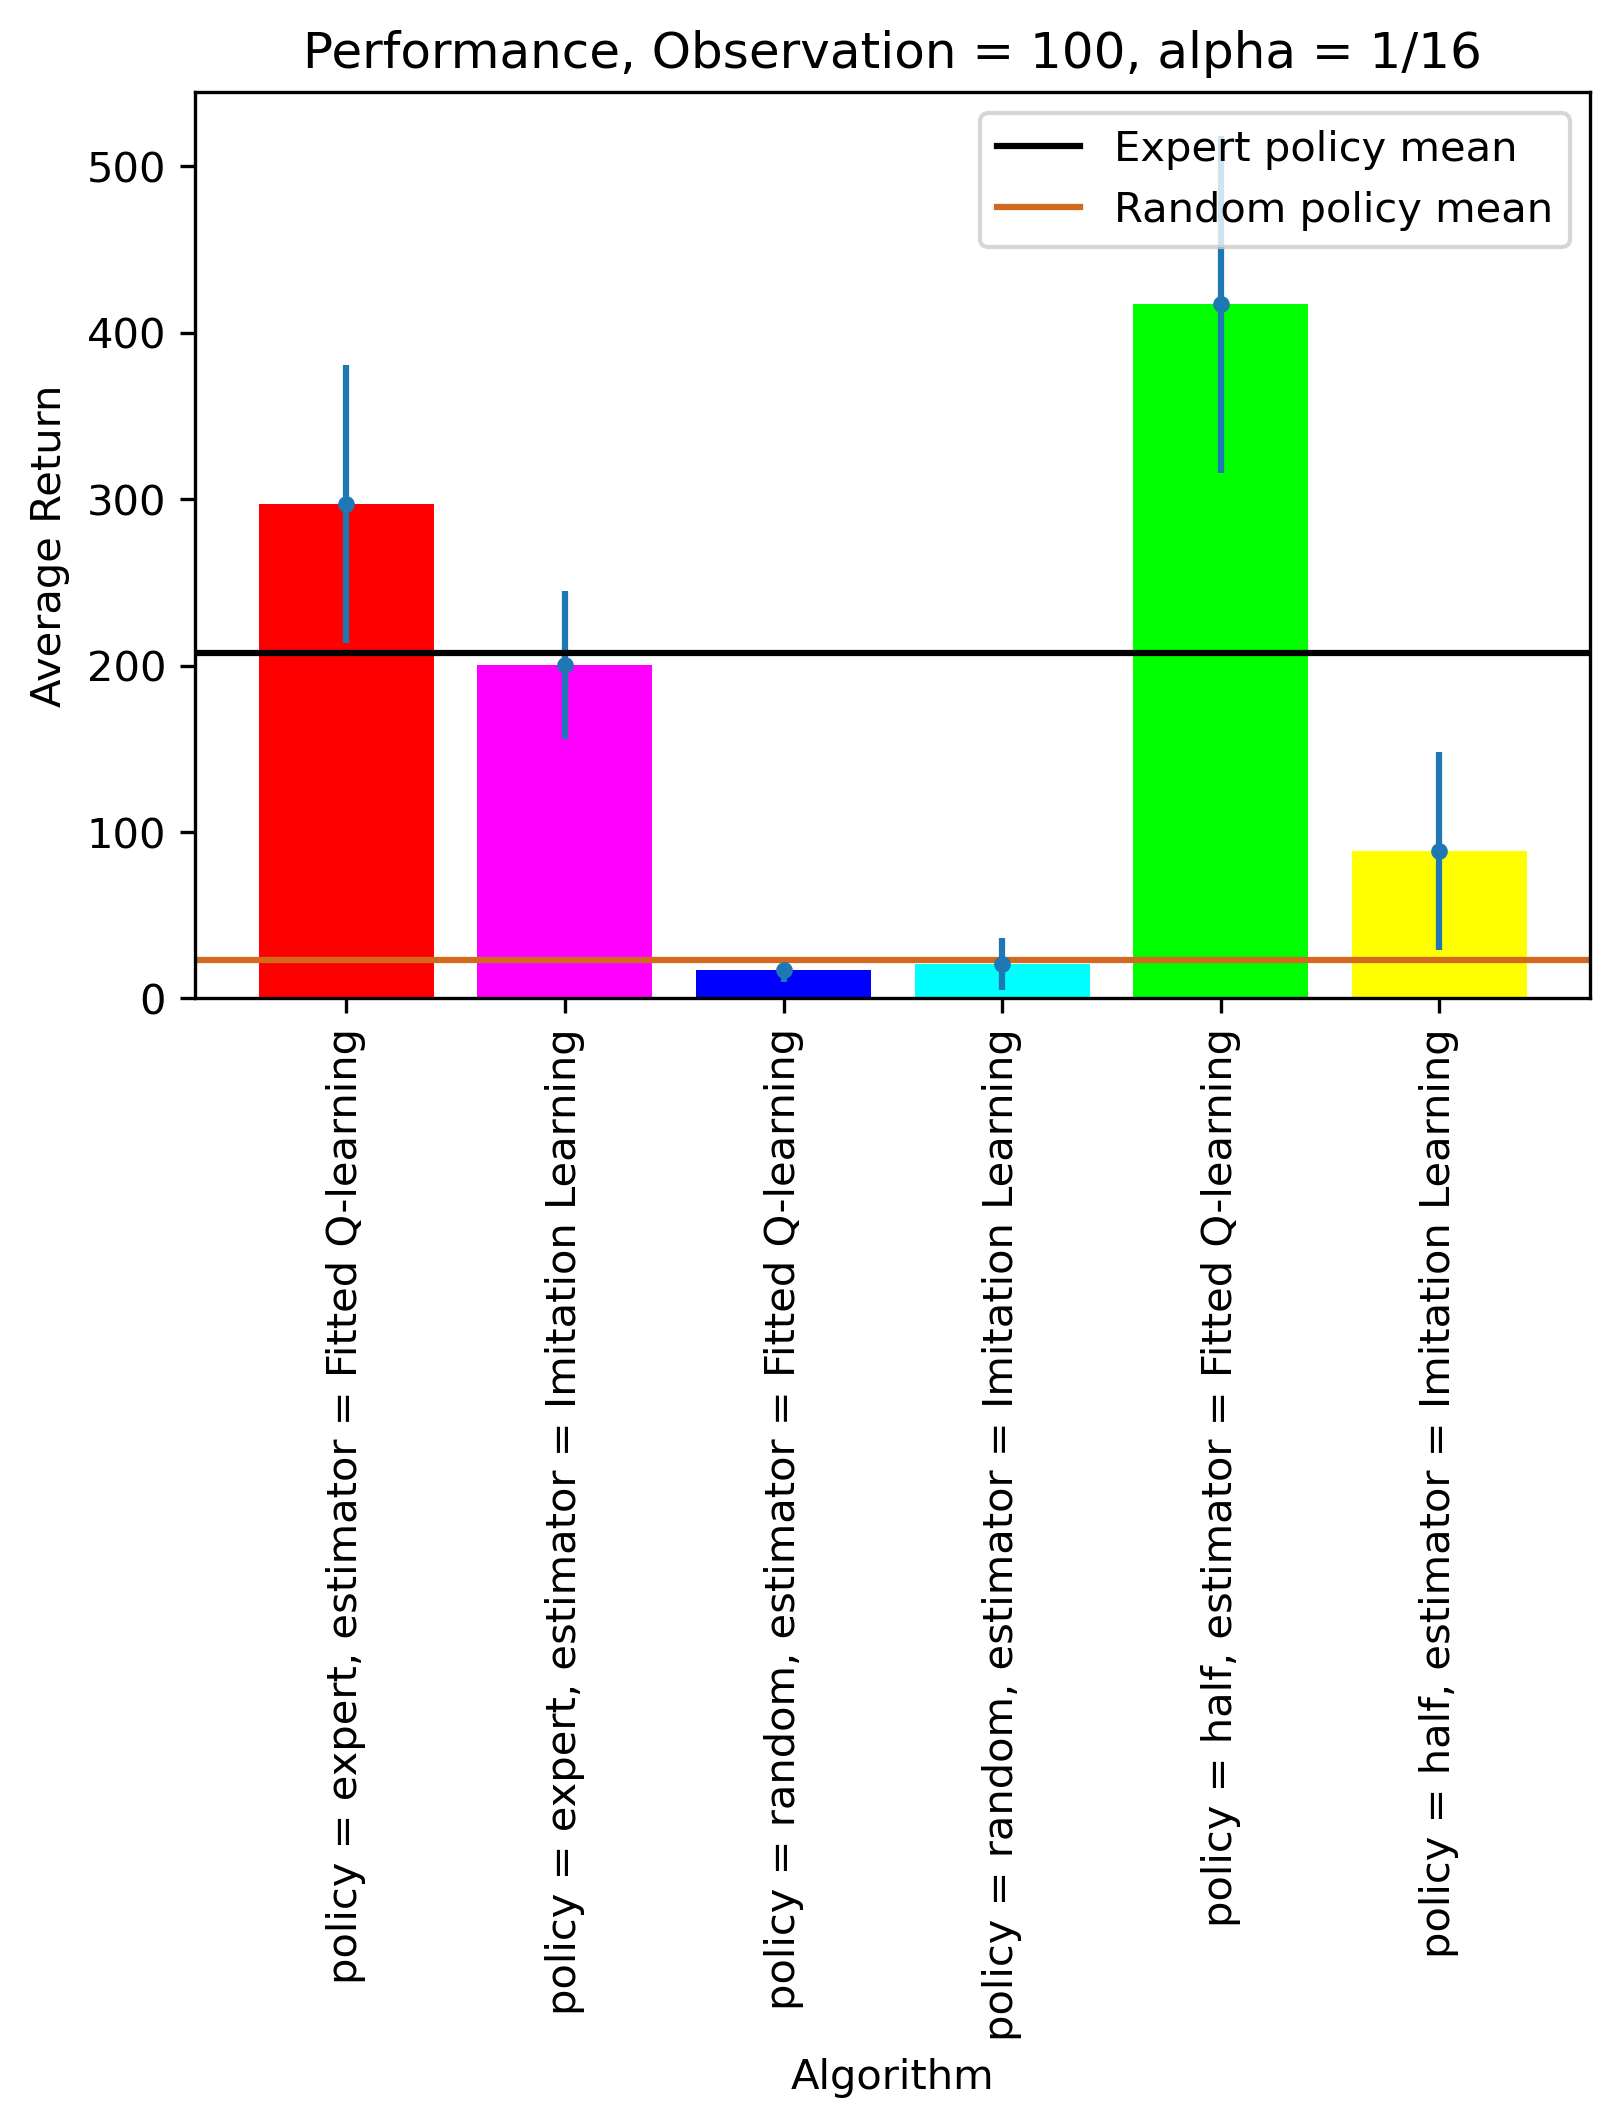

In [21]:
y_axis_1 = []
y_axis_2 = []
y_axis_3 = []
y_axis_4 = []
y_axis_5 = []
y_axis_6 = []


for epidoes in return_expert_fqn_100_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_1.append(sum_e)
    
for epidoes in return_expert_lr_100_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_2.append(sum_e)
    
for epidoes in return_random_fqn_100_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_3.append(sum_e)
    
for epidoes in return_random_lr_100_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_4.append(sum_e)
    
for epidoes in return_half_fqn_100_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_5.append(sum_e)
    
for epidoes in return_half_lr_100_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_6.append(sum_e)
    

y_axis_1_mean = np.mean(y_axis_1)
y_axis_2_mean = np.mean(y_axis_2)      
y_axis_3_mean = np.mean(y_axis_3)
y_axis_4_mean = np.mean(y_axis_4)      
y_axis_5_mean = np.mean(y_axis_5)      
y_axis_6_mean = np.mean(y_axis_6)   

y_axis_1_sd = np.std(y_axis_1)
y_axis_2_sd = np.std(y_axis_2)      
y_axis_3_sd = np.std(y_axis_3)
y_axis_4_sd = np.std(y_axis_4)      
y_axis_5_sd = np.std(y_axis_5)      
y_axis_6_sd = np.std(y_axis_6)

y = []
y.append(y_axis_1_mean)
y.append(y_axis_2_mean)
y.append(y_axis_3_mean)
y.append(y_axis_4_mean)
y.append(y_axis_5_mean)
y.append(y_axis_6_mean)

y_err = []
y_err.append(y_axis_1_sd)
y_err.append(y_axis_2_sd)
y_err.append(y_axis_3_sd)
y_err.append(y_axis_4_sd)
y_err.append(y_axis_5_sd)
y_err.append(y_axis_6_sd)

x = ['policy = expert, estimator = Fitted Q-learning', 
            'policy = expert, estimator = Imitation Learning',
            'policy = random, estimator = Fitted Q-learning',
            'policy = random, estimator = Imitation Learning',
            'policy = half, estimator = Fitted Q-learning',
            'policy = half, estimator = Imitation Learning',
           ]


plt.figure(dpi=300)
plt.bar(x, y, color=['#FF0000','#FF00FF','#0000FF','#00FFFF','#00FF00','#FFFF00'])
plt.errorbar(x, y, y_err, fmt='.')
plt.axhline(expert_mean_100, color='#000000')
plt.axhline(random_mean_100, color='#D2691E')
plt.legend(['Expert policy mean', 'Random policy mean'])
plt.xlabel("Algorithm",)
plt.ylabel("Average Return")
plt.title("Performance, Observation = 100, alpha = 1/16")
plt.xticks(rotation=90)
plt.show()


## Bar Chart for Observation = 250, learning rate = 1/8 

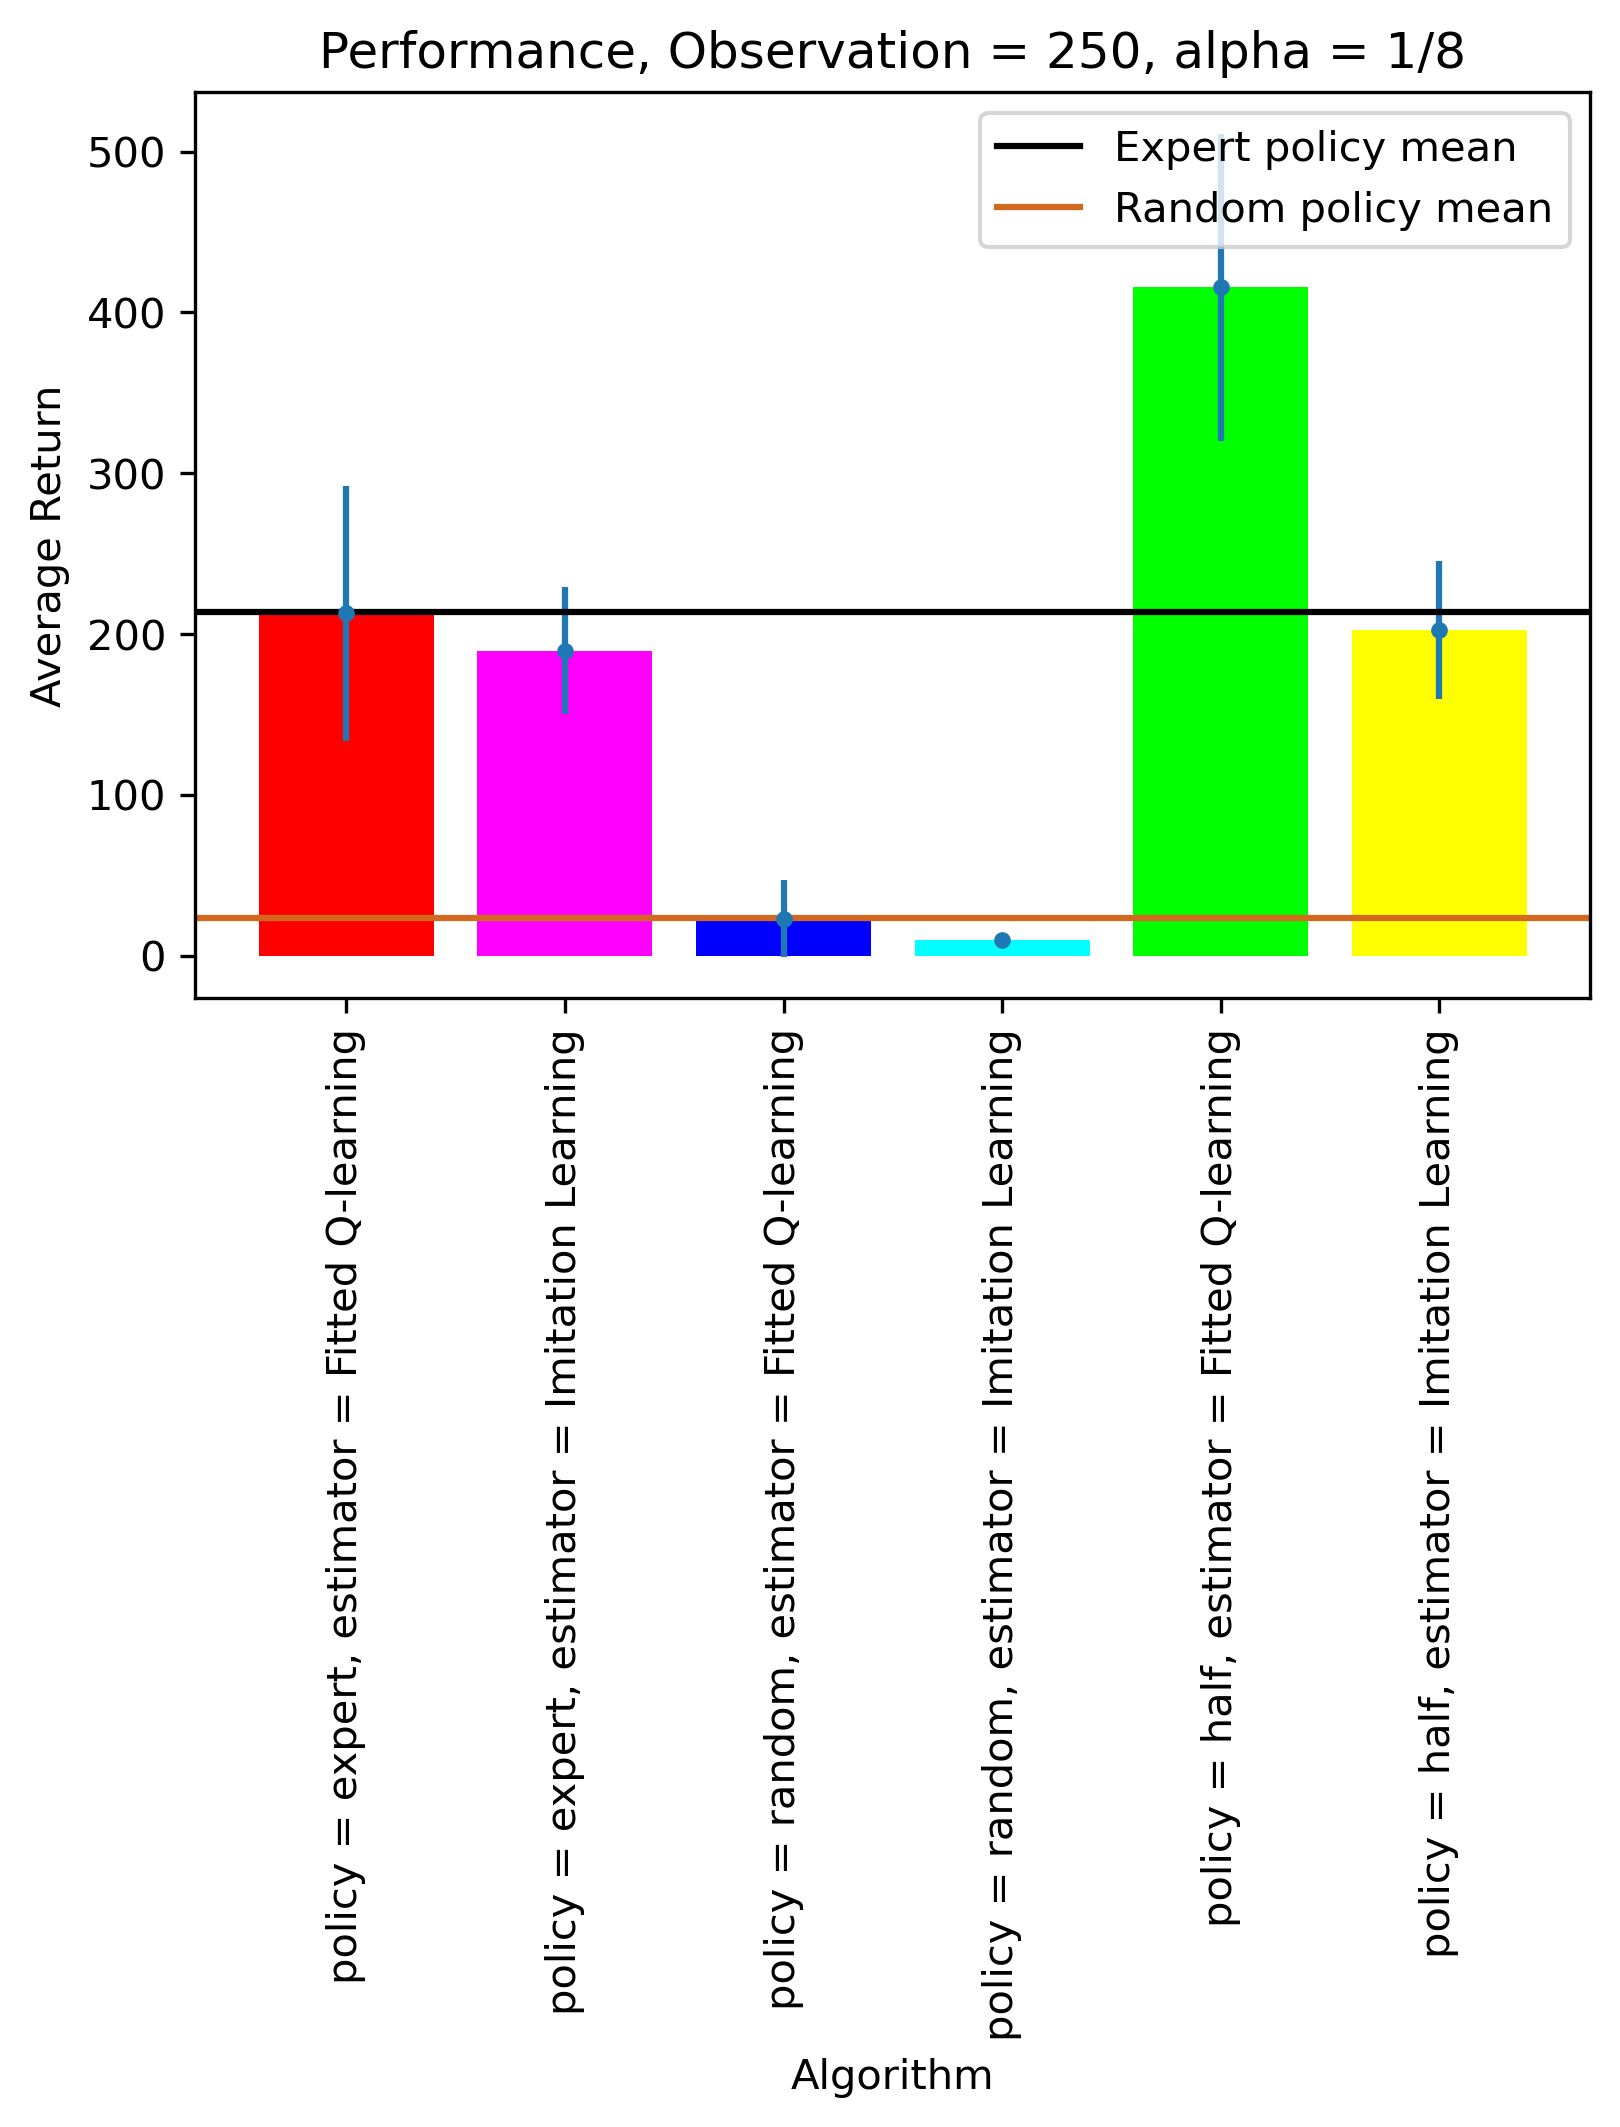

In [22]:
y_axis_1 = []
y_axis_2 = []
y_axis_3 = []
y_axis_4 = []
y_axis_5 = []
y_axis_6 = []


for epidoes in return_expert_fqn_250_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_1.append(sum_e)
    
for epidoes in return_expert_lr_250_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_2.append(sum_e)
    
for epidoes in return_random_fqn_250_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_3.append(sum_e)
    
for epidoes in return_random_lr_250_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_4.append(sum_e)
    
for epidoes in return_half_fqn_250_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_5.append(sum_e)
    
for epidoes in return_half_lr_250_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_6.append(sum_e)
    

y_axis_1_mean = np.mean(y_axis_1)
y_axis_2_mean = np.mean(y_axis_2)      
y_axis_3_mean = np.mean(y_axis_3)
y_axis_4_mean = np.mean(y_axis_4)      
y_axis_5_mean = np.mean(y_axis_5)      
y_axis_6_mean = np.mean(y_axis_6)   

y_axis_1_sd = np.std(y_axis_1)
y_axis_2_sd = np.std(y_axis_2)      
y_axis_3_sd = np.std(y_axis_3)
y_axis_4_sd = np.std(y_axis_4)      
y_axis_5_sd = np.std(y_axis_5)      
y_axis_6_sd = np.std(y_axis_6)

y = []
y.append(y_axis_1_mean)
y.append(y_axis_2_mean)
y.append(y_axis_3_mean)
y.append(y_axis_4_mean)
y.append(y_axis_5_mean)
y.append(y_axis_6_mean)

y_err = []
y_err.append(y_axis_1_sd)
y_err.append(y_axis_2_sd)
y_err.append(y_axis_3_sd)
y_err.append(y_axis_4_sd)
y_err.append(y_axis_5_sd)
y_err.append(y_axis_6_sd)

x = ['policy = expert, estimator = Fitted Q-learning', 
            'policy = expert, estimator = Imitation Learning',
            'policy = random, estimator = Fitted Q-learning',
            'policy = random, estimator = Imitation Learning',
            'policy = half, estimator = Fitted Q-learning',
            'policy = half, estimator = Imitation Learning',
           ]


plt.figure(dpi=300)
plt.bar(x, y, color=['#FF0000','#FF00FF','#0000FF','#00FFFF','#00FF00','#FFFF00'])
plt.errorbar(x, y, y_err, fmt='.')
plt.axhline(expert_mean_250, color='#000000')
plt.axhline(random_mean_250, color='#D2691E')
plt.legend(['Expert policy mean', 'Random policy mean'])
plt.xlabel("Algorithm",)
plt.ylabel("Average Return")
plt.title("Performance, Observation = 250, alpha = 1/8")
plt.xticks(rotation=90)
plt.show()

## Bar Chart for Observation = 250, learning rate = 1/16

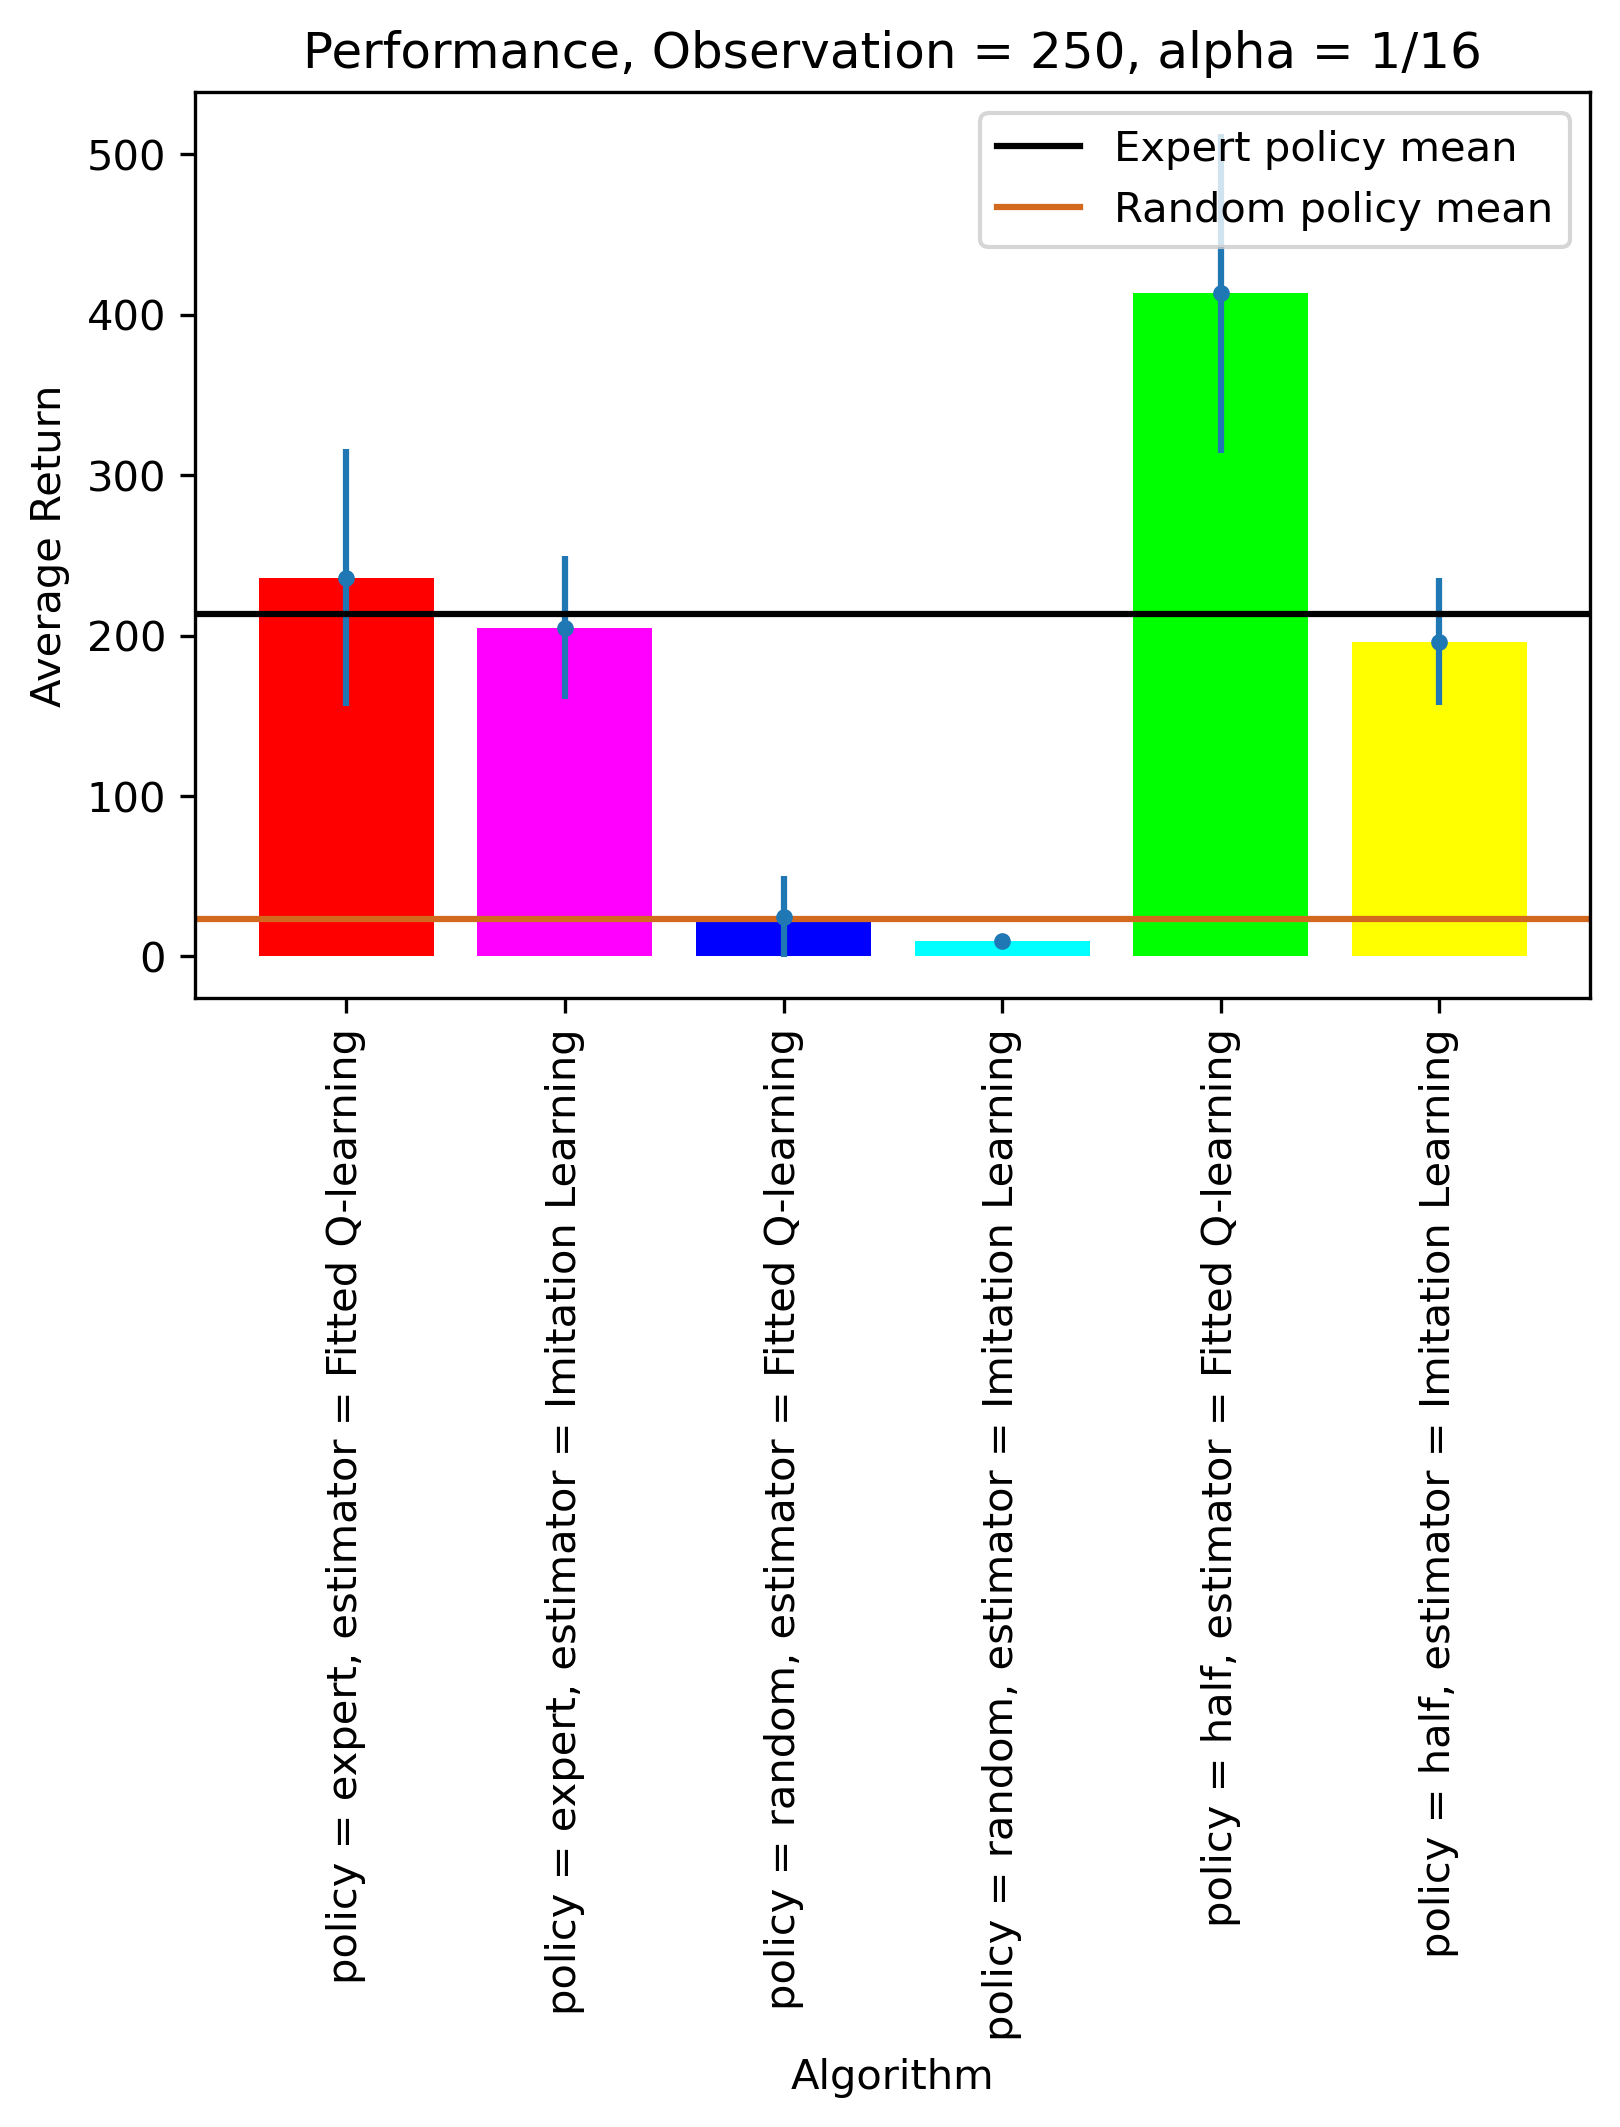

In [23]:
y_axis_1 = []
y_axis_2 = []
y_axis_3 = []
y_axis_4 = []
y_axis_5 = []
y_axis_6 = []


for epidoes in return_expert_fqn_250_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_1.append(sum_e)
    
for epidoes in return_expert_lr_250_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_2.append(sum_e)
    
for epidoes in return_random_fqn_250_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_3.append(sum_e)
    
for epidoes in return_random_lr_250_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_4.append(sum_e)
    
for epidoes in return_half_fqn_250_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_5.append(sum_e)
    
for epidoes in return_half_lr_250_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_6.append(sum_e)
    

y_axis_1_mean = np.mean(y_axis_1)
y_axis_2_mean = np.mean(y_axis_2)      
y_axis_3_mean = np.mean(y_axis_3)
y_axis_4_mean = np.mean(y_axis_4)      
y_axis_5_mean = np.mean(y_axis_5)      
y_axis_6_mean = np.mean(y_axis_6)   

y_axis_1_sd = np.std(y_axis_1)
y_axis_2_sd = np.std(y_axis_2)      
y_axis_3_sd = np.std(y_axis_3)
y_axis_4_sd = np.std(y_axis_4)      
y_axis_5_sd = np.std(y_axis_5)      
y_axis_6_sd = np.std(y_axis_6)

y = []
y.append(y_axis_1_mean)
y.append(y_axis_2_mean)
y.append(y_axis_3_mean)
y.append(y_axis_4_mean)
y.append(y_axis_5_mean)
y.append(y_axis_6_mean)

y_err = []
y_err.append(y_axis_1_sd)
y_err.append(y_axis_2_sd)
y_err.append(y_axis_3_sd)
y_err.append(y_axis_4_sd)
y_err.append(y_axis_5_sd)
y_err.append(y_axis_6_sd)

x = ['policy = expert, estimator = Fitted Q-learning', 
            'policy = expert, estimator = Imitation Learning',
            'policy = random, estimator = Fitted Q-learning',
            'policy = random, estimator = Imitation Learning',
            'policy = half, estimator = Fitted Q-learning',
            'policy = half, estimator = Imitation Learning',
           ]


plt.figure(dpi=300)
plt.bar(x, y, color=['#FF0000','#FF00FF','#0000FF','#00FFFF','#00FF00','#FFFF00'])
plt.errorbar(x, y, y_err, fmt='.')
plt.axhline(expert_mean_250, color='#000000')
plt.axhline(random_mean_250, color='#D2691E')
plt.legend(['Expert policy mean', 'Random policy mean'])
plt.xlabel("Algorithm",)
plt.ylabel("Average Return")
plt.title("Performance, Observation = 250, alpha = 1/16")
plt.xticks(rotation=90)
plt.show()

## Bar Chart for Observation = 500, learning rate = 1/8 

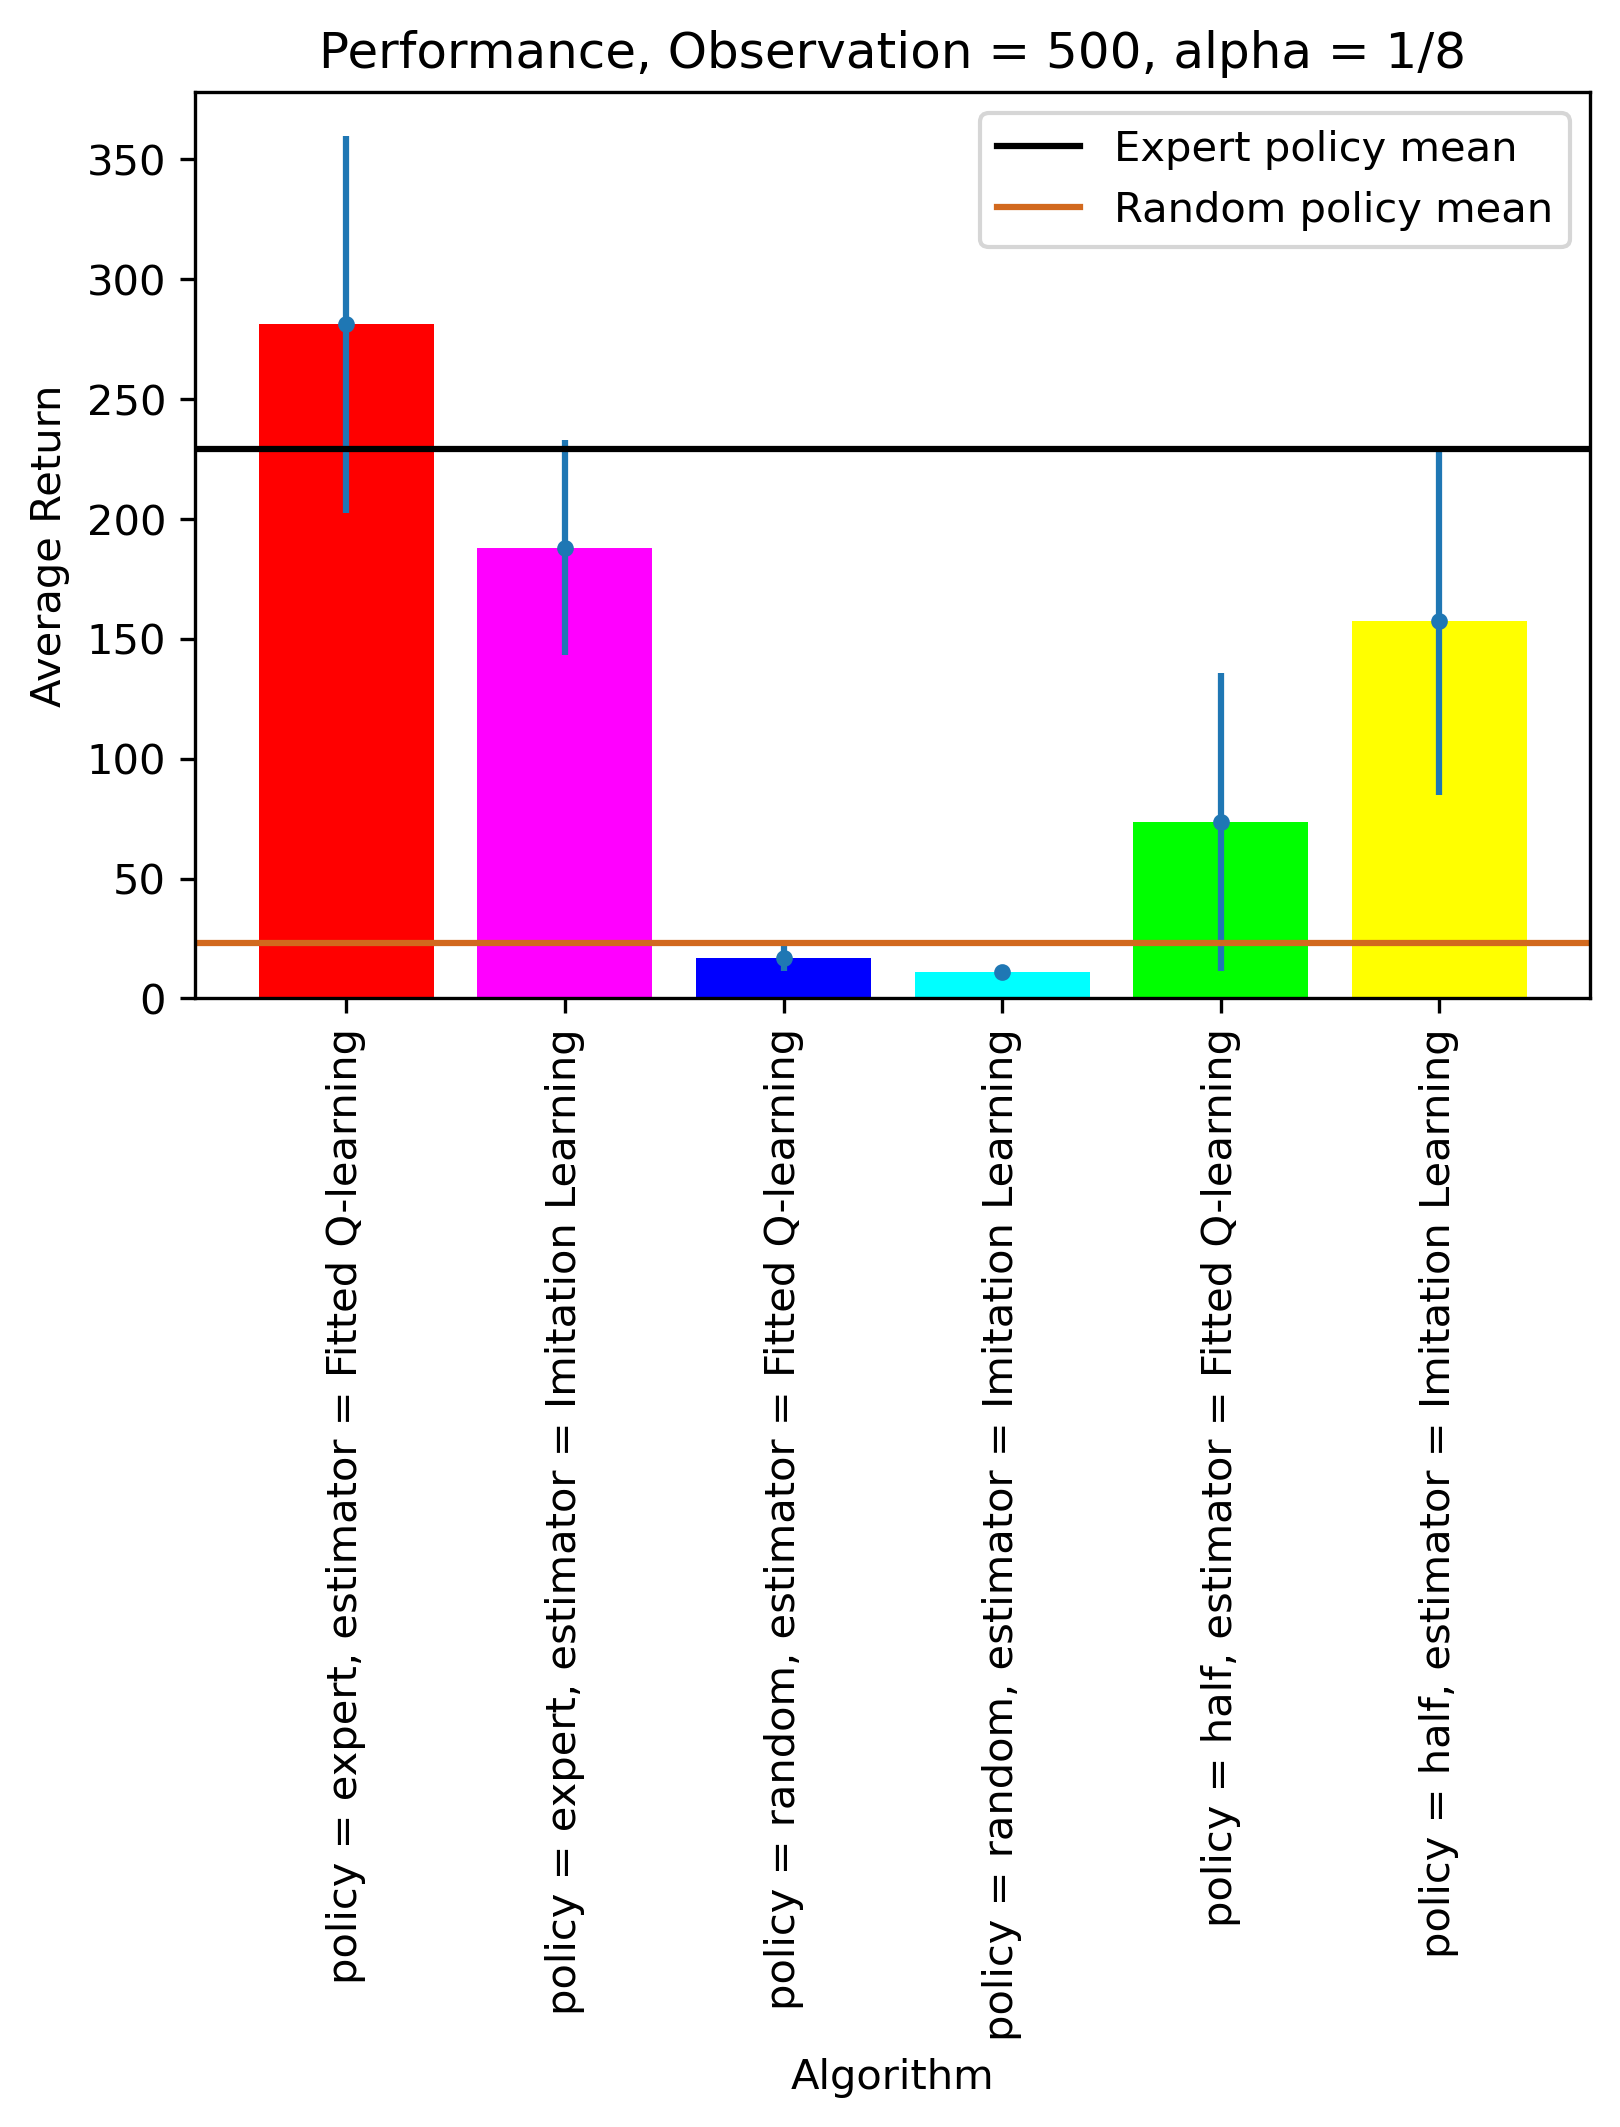

In [24]:
y_axis_1 = []
y_axis_2 = []
y_axis_3 = []
y_axis_4 = []
y_axis_5 = []
y_axis_6 = []


for epidoes in return_expert_fqn_500_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_1.append(sum_e)
    
for epidoes in return_expert_lr_500_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_2.append(sum_e)
    
for epidoes in return_random_fqn_500_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_3.append(sum_e)
    
for epidoes in return_random_lr_500_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_4.append(sum_e)
    
for epidoes in return_half_fqn_500_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_5.append(sum_e)
    
for epidoes in return_half_lr_500_alpha1:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_6.append(sum_e)
    

y_axis_1_mean = np.mean(y_axis_1)
y_axis_2_mean = np.mean(y_axis_2)      
y_axis_3_mean = np.mean(y_axis_3)
y_axis_4_mean = np.mean(y_axis_4)      
y_axis_5_mean = np.mean(y_axis_5)      
y_axis_6_mean = np.mean(y_axis_6)   

y_axis_1_sd = np.std(y_axis_1)
y_axis_2_sd = np.std(y_axis_2)      
y_axis_3_sd = np.std(y_axis_3)
y_axis_4_sd = np.std(y_axis_4)      
y_axis_5_sd = np.std(y_axis_5)      
y_axis_6_sd = np.std(y_axis_6)

y = []
y.append(y_axis_1_mean)
y.append(y_axis_2_mean)
y.append(y_axis_3_mean)
y.append(y_axis_4_mean)
y.append(y_axis_5_mean)
y.append(y_axis_6_mean)

y_err = []
y_err.append(y_axis_1_sd)
y_err.append(y_axis_2_sd)
y_err.append(y_axis_3_sd)
y_err.append(y_axis_4_sd)
y_err.append(y_axis_5_sd)
y_err.append(y_axis_6_sd)

x = ['policy = expert, estimator = Fitted Q-learning', 
            'policy = expert, estimator = Imitation Learning',
            'policy = random, estimator = Fitted Q-learning',
            'policy = random, estimator = Imitation Learning',
            'policy = half, estimator = Fitted Q-learning',
            'policy = half, estimator = Imitation Learning',
           ]


plt.figure(dpi=300)
plt.bar(x, y, color=['#FF0000','#FF00FF','#0000FF','#00FFFF','#00FF00','#FFFF00'])
plt.errorbar(x, y, y_err, fmt='.')
plt.axhline(expert_mean_500, color='#000000')
plt.axhline(random_mean_500, color='#D2691E')
plt.legend(['Expert policy mean', 'Random policy mean'])
plt.xlabel("Algorithm",)
plt.ylabel("Average Return")
plt.title("Performance, Observation = 500, alpha = 1/8")
plt.xticks(rotation=90)
plt.show()

## Bar Chart for Observation = 500, learning rate = 1/16

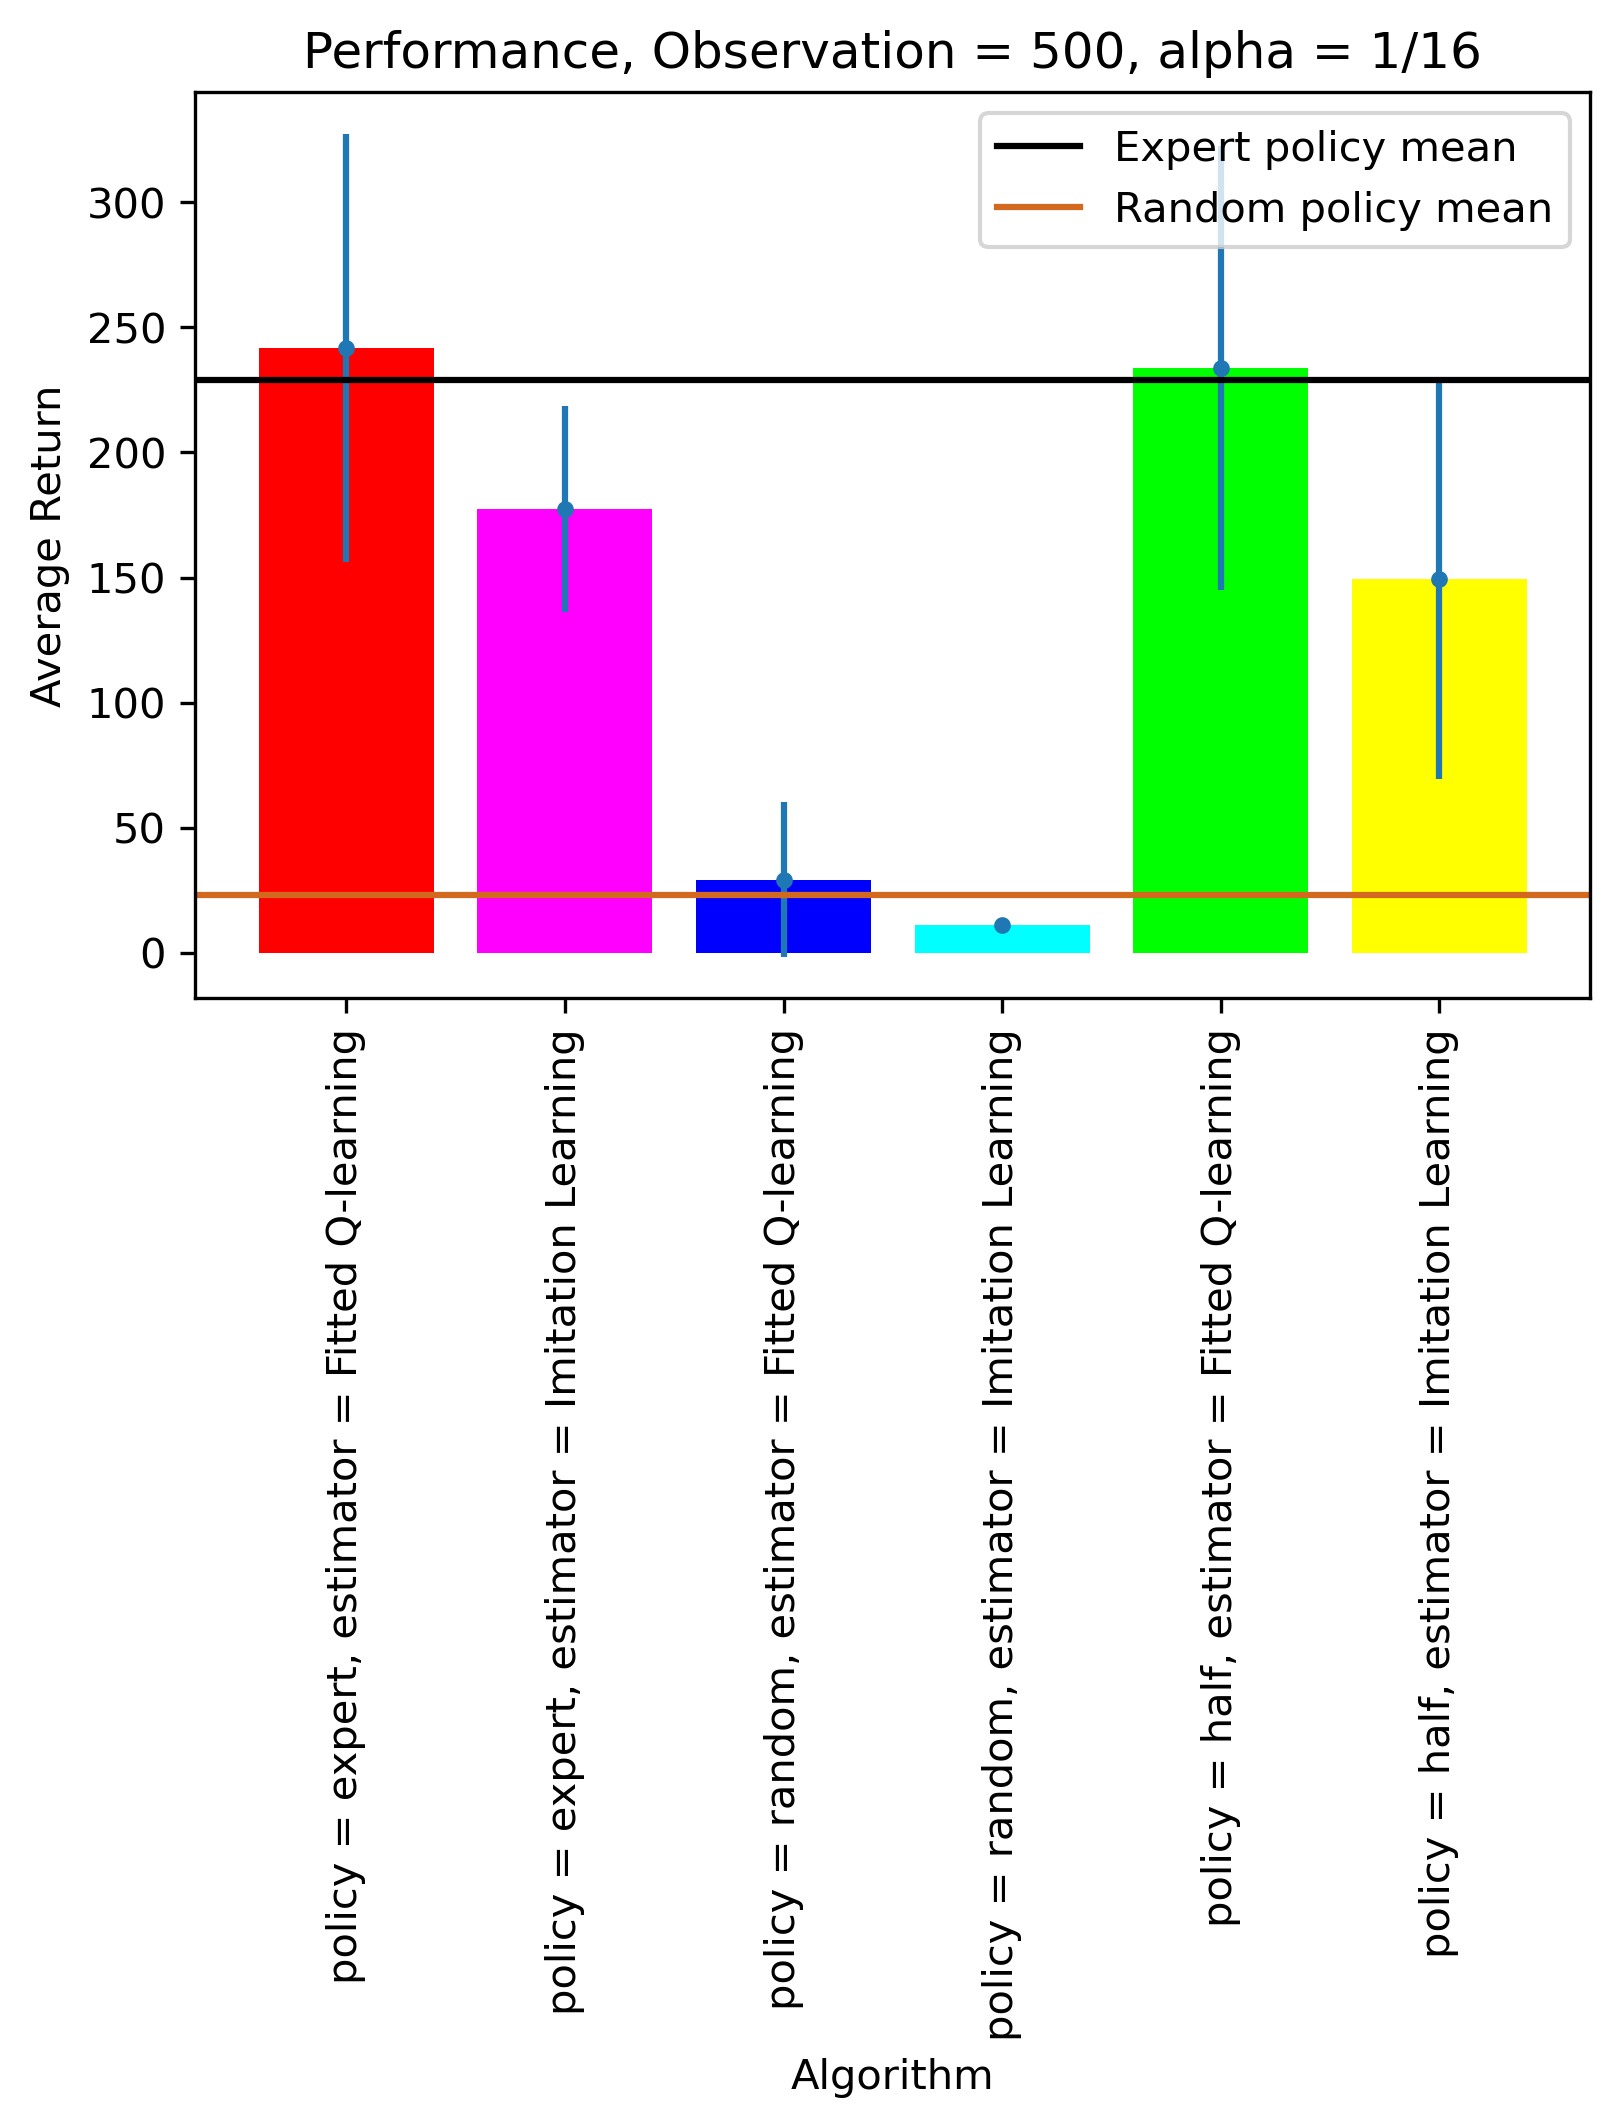

In [25]:
y_axis_1 = []
y_axis_2 = []
y_axis_3 = []
y_axis_4 = []
y_axis_5 = []
y_axis_6 = []


for epidoes in return_expert_fqn_500_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_1.append(sum_e)
    
for epidoes in return_expert_lr_500_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_2.append(sum_e)
    
for epidoes in return_random_fqn_500_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_3.append(sum_e)
    
for epidoes in return_random_lr_500_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_4.append(sum_e)
    
for epidoes in return_half_fqn_500_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_5.append(sum_e)
    
for epidoes in return_half_lr_500_alpha2:
    sum_e = 0
    for returns in epidoes:
        sum_e = sum_e + returns[2]
    y_axis_6.append(sum_e)
    

y_axis_1_mean = np.mean(y_axis_1)
y_axis_2_mean = np.mean(y_axis_2)      
y_axis_3_mean = np.mean(y_axis_3)
y_axis_4_mean = np.mean(y_axis_4)      
y_axis_5_mean = np.mean(y_axis_5)      
y_axis_6_mean = np.mean(y_axis_6)   

y_axis_1_sd = np.std(y_axis_1)
y_axis_2_sd = np.std(y_axis_2)      
y_axis_3_sd = np.std(y_axis_3)
y_axis_4_sd = np.std(y_axis_4)      
y_axis_5_sd = np.std(y_axis_5)      
y_axis_6_sd = np.std(y_axis_6)

y = []
y.append(y_axis_1_mean)
y.append(y_axis_2_mean)
y.append(y_axis_3_mean)
y.append(y_axis_4_mean)
y.append(y_axis_5_mean)
y.append(y_axis_6_mean)

y_err = []
y_err.append(y_axis_1_sd)
y_err.append(y_axis_2_sd)
y_err.append(y_axis_3_sd)
y_err.append(y_axis_4_sd)
y_err.append(y_axis_5_sd)
y_err.append(y_axis_6_sd)

x = ['policy = expert, estimator = Fitted Q-learning', 
            'policy = expert, estimator = Imitation Learning',
            'policy = random, estimator = Fitted Q-learning',
            'policy = random, estimator = Imitation Learning',
            'policy = half, estimator = Fitted Q-learning',
            'policy = half, estimator = Imitation Learning',
           ]


plt.figure(dpi=300)
plt.bar(x, y, color=['#FF0000','#FF00FF','#0000FF','#00FFFF','#00FF00','#FFFF00'])
plt.errorbar(x, y, y_err, fmt='.')
plt.axhline(expert_mean_500, color='#000000')
plt.axhline(random_mean_500, color='#D2691E')
plt.legend(['Expert policy mean', 'Random policy mean'])
plt.xlabel("Algorithm",)
plt.ylabel("Average Return")
plt.title("Performance, Observation = 500, alpha = 1/16")
plt.xticks(rotation=90)
plt.show()

## Report

### Environment: Cart-pole_v1

### Experiment:
<br>I, first, define the discrete state for the cart pole environment to create Q-function value table for each of the two agents. Then, I pre-trained the two agents with 80,000 samples (Independent episodes) and update their Q-table. I use these Q-value tables to collect observation datasets of sizes 100, 250 and 500. I use these datasets to train Imitation Learning (Logistic Regression) and Fitted Q-Learning estimator, with two different learning rates. I then run Greedy Algorithm for 100 episodes and collect the returns. I plot these returns to visualize their performance.

### Results:

**when dataset size is 100 and learning rate is 1/8**

Fitted Q-learning performs slightly better than Imitation Learning, when trained with Expert policy dataset and Half policy dataset. Fitted Q-learning trained with Expert and half policy dataset, and Imitation Learning perform trained with Expert policy dataset have a high average episode returns, Fitted Q-learning trained with Expert agent and Imitation Learning perform trained with Expert have higher returns than expert policy. Both of the algorithms perform very poorly when trained with Random policy dataset. 

**when dataset size is 100 and learning rate is 1/16**

Again, Fitted Q-learning performs slightly better than Imitation Learning, when trained with Expert policy dataset and Half policy dataset. Fitted Q-learning trained with Expert and half policy dataset, and Imitation Learning perform trained with Expert and Half policy dataset have a high average episode returns, Fitted Q-learning trained with Expert agent and Imitation Learning perform trained with Expert have equal or higher average returns than expert policy. Both of the algorithms perform very poorly when trained with Random policy dataset. 

**Impact of Learning rate**

The learning rate does have any significant changes in the performance of the two algorithms trained under different datasets; the performance of Imitation learning trained with Half policy dataset is higher with the learning rate is 0.001 than 0.01 

**when dataset size is 250 and learning rate is 1/8**

Fitted Q-learning performs slightly better than Imitation Learning, when trained with Expert policy dataset and Half policy dataset. Fitted Q-learning trained with Expert and half policy dataset, and Imitation Learning perform trained with Expert and Half policy dataset have a high average episode returns, Fitted Q-learning trained with Expert agent and Imitation Learning perform trained with Expert have equal or higher average returns than expert policy. Both of the algorithms perform very poorly when trained with Random policy dataset.  

**when dataset size is 250 and learning rate is 1/16**

Again, Fitted Q-learning performs slightly better than Imitation Learning, when trained with Expert policy dataset and Half policy dataset. Fitted Q-learning trained with Expert and half policy dataset, and Imitation Learning perform trained with Expert and Half policy dataset have a high average episode returns, Fitted Q-learning trained with Expert agent and Imitation Learning perform trained with Expert have equal or higher average returns than expert policy. Both of the algorithms perform very poorly when trained with Random policy dataset. 

**Impact of Learning rate**

The change in the learning rate does not make any significant changes in the performance of the algorithm under different datasets. 

**when dataset size is 500 and learning rate is 1/8**

Fitted Q-learning trained with Expert and half policy dataset, and Imitation Learning perform trained with Half policy dataset have a high average episode returns, Fitted Q-learning trained with Expert policy dataset have higher average returns than expert agent. Both of the algorithms perform very poorly when trained with Random policy dataset.  

**when dataset size is 500 and learning rate is 1/16**

Fitted Q-learning trained with Expert and Half policy dataset, and Imitation Learning perform trained with Expert and Half policy dataset have a high average episode returns, Fitted Q-learning trained with Expert policy dataset and Imitation Learning perform trained with Expert policy dataset have higher average returns than expert agent. Both of the algorithms perform very poorly when trained with Random policy dataset. 

**Impact of Learning rate**

The learning rate does have any significant changes in the performance of the two algorithms trained under different datasets; the performance of Fitted Q-learning trained with Half policy dataset is higher with the learning rate is 0.001 than 0.01 

### Conclusion:
The Fitted Q-Learning performs slightly better than the Imitation learning. It performs better when trained with the dataset collected with the Expert policy or the Half policy than the Random policy.

### Impact of size:
Increase in the size of dataset does have any significant changes in the performance of the two algorithms, however both algorithms (Imitation Learning and Fitted Q-learning) tends to perform better with a dataset trained with Expert policy as the size of dataset increases.

